# Multi-Task Fine-Tune

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-8xwn5fqo
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-8xwn5fqo
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.7 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchinfo
import segmentation_models_pytorch as smp
from transformers import get_linear_schedule_with_warmup

In [3]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


In [4]:
!nvidia-smi

Thu Apr  6 09:51:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# prepare data
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip
  inflating: img.npy                 
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip
  inflating: label.npy               
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip
  inflating: size.npy                


In [7]:
test_img = np.load('img.npy')
print(test_img.shape)

test_label = np.load('label.npy')
print(test_label.shape)

test_size = np.load('size.npy')
print(test_size.shape)

(7390, 256, 256, 3)
(7390, 256, 256)
(7390, 2)


In [22]:
test_label[test_label==1] = 0
test_label[test_label==2] = 1
test_label[test_label==3] = 2

np.unique(test_label)

(7390, 256, 256)


array([0, 1], dtype=uint8)

[170 256]


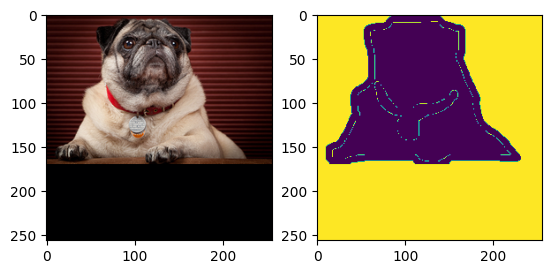

In [23]:
_, ax = plt.subplots(nrows = 1,ncols = 2)
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1])
print(test_size[1])

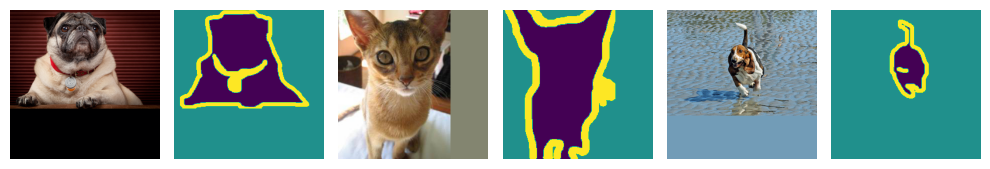

In [ ]:

fig,ax = plt.subplots(nrows = 1,ncols =6, figsize =(10,10))

ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1])
ax[2].imshow(test_img[12])
ax[3].imshow(test_label[12])
ax[4].imshow(test_img[13])
ax[5].imshow(test_label[13])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[5].axis('off')
plt.tight_layout()
plt.show()

## Classification Labels

In [24]:
from tqdm import tqdm

file_names = np.load('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/file_names.npy')

with open('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/list.txt', 'r') as file:
    lines = file.readlines()

clf_labels = [0] * len(file_names)
for line in tqdm(lines[6:]):
    i = list(file_names).index(line.strip().split(' ')[0])
    clf_labels[i] = int(line.strip().split(' ')[2])

clf_labels = np.array(clf_labels)

np.save('/content/drive/MyDrive/Colab Notebooks/ADL Group Project/clf_labels.npy', clf_labels)

np.unique(clf_labels)

100%|██████████| 7349/7349 [00:15<00:00, 469.76it/s]


array([0, 1, 2])

## Generate Padding Masks

In [25]:
test_mask = np.zeros_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  test_mask[i,0:test_size[i,0],0:test_size[i,1]] = 1

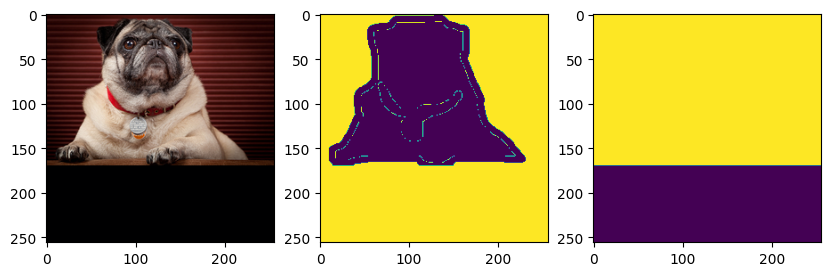

In [26]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1].astype(int))
ax[2].imshow(test_mask[1]*255.)

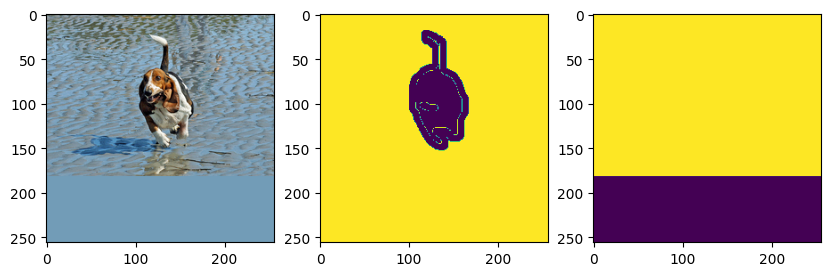

In [27]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[13])
ax[1].imshow(test_label[13].astype(int))
ax[2].imshow(test_mask[13]*255.)

## Dataset

In [28]:
class Finetune_set(Dataset):
  
  def __init__(self, img, label, mask, clf_label):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() 
    self.mask = torch.Tensor(mask).float()
    self.clf_label = torch.Tensor(clf_label).float() 

  def __len__(self):
    return len(self.img)

  def __getitem__(self, idx):
    return self.img[idx], self.label[idx], self.mask[idx], self.clf_label[idx]

In [30]:
np.random.seed(42)

ids = list(range(test_img.shape[0]))
np.random.shuffle(ids)

# 40% labelled data, 60% unlabelled data
labelled_ids = ids[:int(0.4*test_img.shape[0])]
unlabelled_ids = ids[int(0.4*test_img.shape[0]):]

# 80% training, 5% validation, 15% test
train_ids = labelled_ids[:int(0.8*len(labelled_ids))]
valid_ids = labelled_ids[int(0.8*len(labelled_ids)):int(0.85*len(labelled_ids))]
test_ids = labelled_ids[int(0.85*len(labelled_ids)):]

# validation and test sets stay the same
valid_set = Finetune_set(test_img[valid_ids], test_label[valid_ids], test_mask[valid_ids], clf_labels[valid_ids])
test_set = Finetune_set(test_img[test_ids], test_label[test_ids], test_mask[test_ids], clf_labels[test_ids])
print(len(valid_set), len(test_set))

# training set for baseline and semi-supervised
base_train_set = Finetune_set(test_img[train_ids], test_label[train_ids], test_mask[train_ids], clf_labels[train_ids])
print(len(base_train_set))

# training set for upper bound
upper_train_set = Finetune_set(test_img[train_ids+unlabelled_ids], test_label[train_ids+unlabelled_ids], test_mask[train_ids+unlabelled_ids], clf_labels[train_ids+unlabelled_ids])
print(len(upper_train_set))

148 444
2364
6798


In [32]:
len(unlabelled_ids)

4434

In [33]:
len(labelled_ids)

2956

In [ ]:
batch_size = 64

# validation and test sets stay the same
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=2)

# need to choice which trainset to use
train_loader = DataLoader(upper_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

## Load Pre-trained Model

In [ ]:
aux_params = dict(
    pooling='avg',       # 'avg' or 'max'
    dropout=0.5,         # dropout ratio, default is None
    activation=None,     # 'sigmoid' or None
    classes=3,           # number of output labels: 0 (dog), 1 (cat)
    )

finetune_model = smp.Unet(
    encoder_name="resnet34",         # use ResNet34 as backbone
    encoder_weights=None,            # use randomly initialized weights
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    decoder_use_batchnorm=True,      # if True, BatchNorm2d layer between Conv2D and Activation layers is used
    decoder_attention_type=None,     # attention module used in decoder (default=None)
    in_channels=4,                   # number of input channels, 1 additional attention mask (default=3, expects RGB images)
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for trimaps
    aux_params=aux_params,           # parameters of the auxiliary output (defualt=None)
)

# # load pre-trained weights
# ckpt = torch.load('pre-trained.pth')
# finetune_model.encoder.load_state_dict(ckpt['encoder'])
# finetune_model.decoder.load_state_dict(ckpt['decoder'])

finetune_model.to(device)
print('Pre-trained model weights loaded.')

## Dimension Check

In [ ]:
img, label, mask, clf_label = next(iter(train_loader))

In [ ]:
img.shape

torch.Size([64, 3, 256, 256])

In [ ]:
label.shape

torch.Size([64, 256, 256])

In [ ]:
mask.shape

torch.Size([64, 256, 256])

In [ ]:
clf_label.shape

torch.Size([64])

In [ ]:
concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
concated.shape

torch.Size([64, 4, 256, 256])

In [ ]:
finetune_model.eval()
with torch.no_grad():
    outputs, clf_outputs = finetune_model(concated.to(device))

In [ ]:
outputs.shape

torch.Size([64, 3, 256, 256])

In [ ]:
clf_outputs.shape

torch.Size([64, 3])

In [ ]:
trimap = torch.argmax(outputs, dim=1).detach().cpu()
trimap.shape

torch.Size([64, 256, 256])

In [ ]:
trimap.unique()

tensor([0, 1, 2])

## Inference

In [ ]:
def inference(image, label, mask, model, device):

    concated = torch.concat([image, mask.unsqueeze(0)], dim=0).to(device)

    model.eval()
    with torch.no_grad():
        output, clf_output = model(concated.unsqueeze(0))
    
    trimap = torch.argmax(output.squeeze().detach().cpu().permute(1,2,0), dim=2)

    _, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
    ax[0].imshow(image.permute(1,2,0).cpu())
    ax[1].imshow(label.cpu())
    ax[2].imshow(trimap)
    ax[3].imshow(mask.cpu()*255.)
    plt.show()

    return torch.softmax(clf_output)

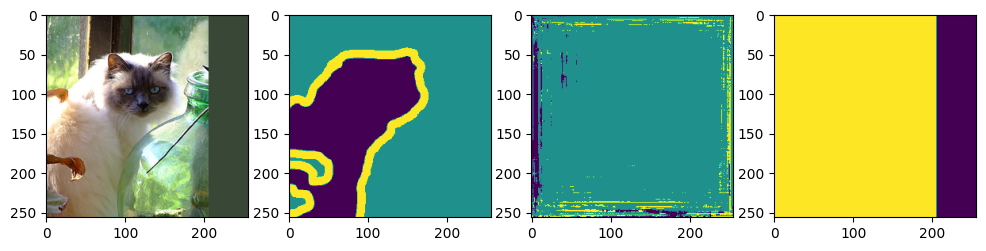

tensor([[1.0000, 0.0000, 1.0000]], device='cuda:0')

In [ ]:
inference(img[0], label[0], mask[0], finetune_model, device)

# Fine-Tune on Semantic Segmentation




In [ ]:
lr = 3e-4
save_step = 50
training_step = 10*500
warm_up = int(0.2*training_step)

seg_w, clf_w = 1.0, 0.1
clf_criterion = nn.CrossEntropyLoss()
seg_criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(finetune_model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)

In [ ]:
model_name = 'upper'

loss_list, valid_loss_list = [], []
step = 0

stop = 0
best_loss = float('inf')

while True:

    for X in train_loader:

        img, label, mask, clf_label = X[0].to(device), X[1].long().to(device), X[2].to(device), X[3].to(device)
        concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 

        finetune_model.train()
        output, clf_output = finetune_model(concated)
        seg_loss = seg_criterion(output*(mask.unsqueeze(1)), (label*mask).long())
        clf_loss = clf_criterion(clf_output.squeeze(), clf_label.squeeze().long())
        # need to normalize loss
        loss = seg_w * seg_loss + clf_w * clf_loss
        loss_list.append(seg_loss.item())
        print(f"step: {step+1}, seg_loss: {seg_loss.item():.8f}, clf_loss: {clf_loss.item():.8f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1

        if step % save_step == 0:
            print(40*'-')
            finetune_model.eval()
            total_loss = 0.0
            for X in valid_loader:
                img, label, mask, clf_label = X[0].to(device), X[1].long().to(device), X[2].to(device), X[3].to(device)
                concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
                with torch.no_grad():
                    output, clf_output = finetune_model(concated)
                loss = seg_criterion(output*(mask.unsqueeze(1)), (label*mask).long())
                total_loss += loss.item() * img.shape[0]
            valid_loss = total_loss/len(valid_loader.dataset)
            valid_loss_list.append(valid_loss)
            print(f'Averaged Train Loss: {np.mean(loss_list):.8f}, Validation Loss: {valid_loss:.8f}')
            
            inference(img[0], label[0], mask[0], finetune_model, device)
            
            model_state_dict = {'encoder': finetune_model.encoder.state_dict(),
                                'decoder': finetune_model.decoder.state_dict(),
                                'mask': finetune_model.segmentation_head.state_dict(),
                                'optimizer': optimizer.state_dict(),
                                'scheduler': scheduler.state_dict()}
            torch.save(model_state_dict, f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_multi.pth')
            print(f'Model checkpoint saved at step {step}')
            print(40*'-')

            if valid_loss >= best_loss:
                stop += 1
            else:
                best_loss = valid_loss 
                stop = 0

            if stop >= 5:
                print('Early stopped at step: ', step)

        if step == training_step:
            break
            
    if step == training_step:
        break

np.save(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_loss_multi.npy', np.array(loss_list))
np.save(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_valid_loss_multi.npy', np.array(valid_loss_list))

Output hidden; open in https://colab.research.google.com to view.

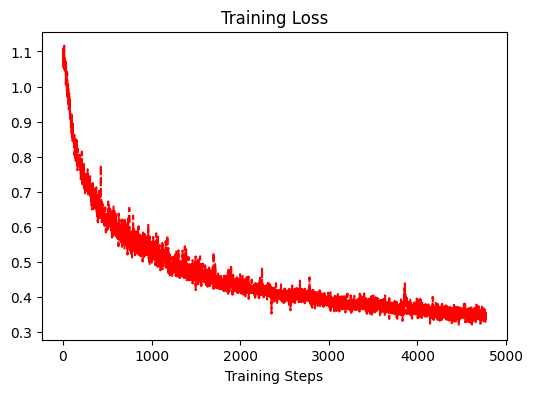

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(loss_list, 'r--')
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.show()

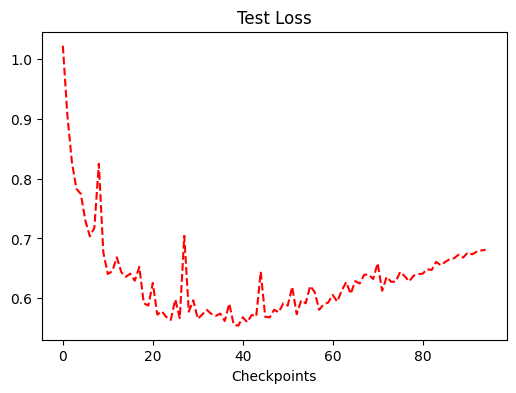

In [ ]:
jinplt.figure(figsize=(6,4))
plt.plot(test_loss_list, 'r--')
plt.title('Test Loss')
plt.xlabel('Checkpoints')
plt.show()

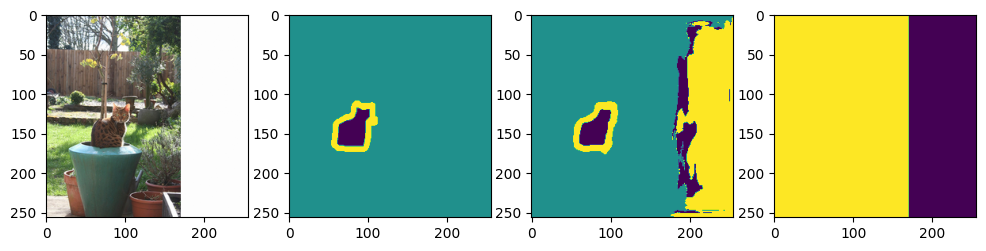

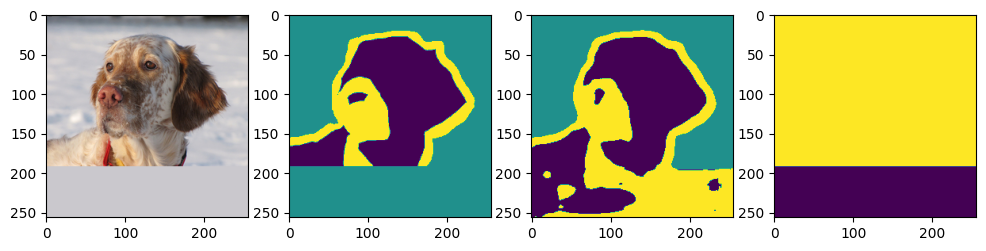

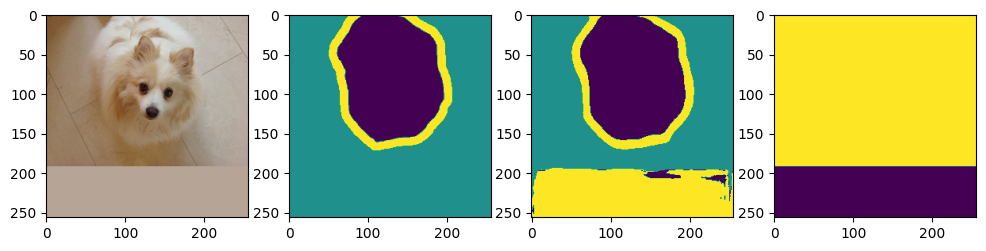

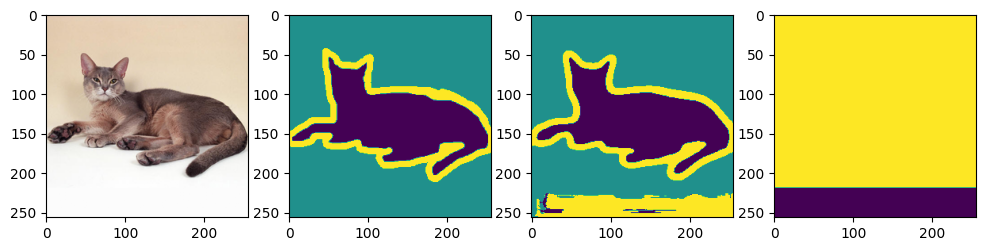

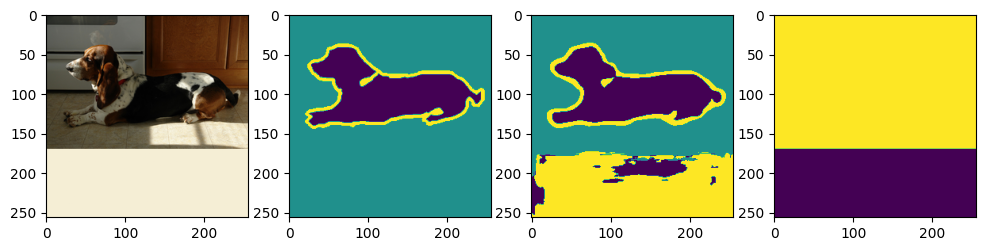

In [ ]:
img, label, mask, clf_label = next(iter(train_loader))

for i in range(5):
    i += 5
    inference(img[i], label[i], mask[i], finetune_model, device)

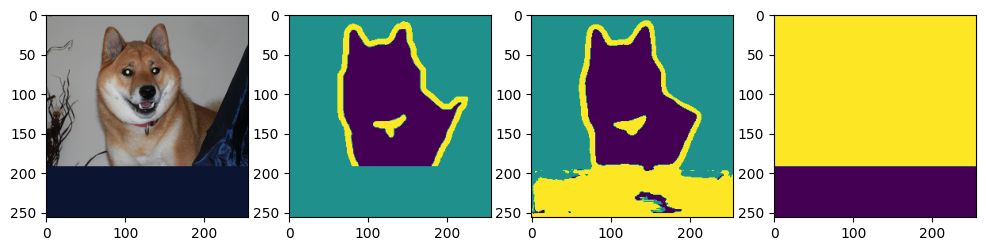

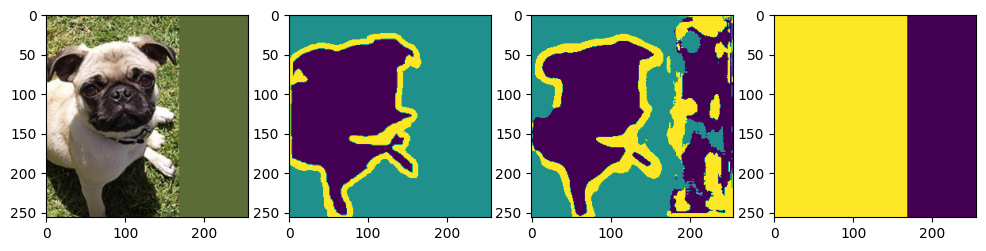

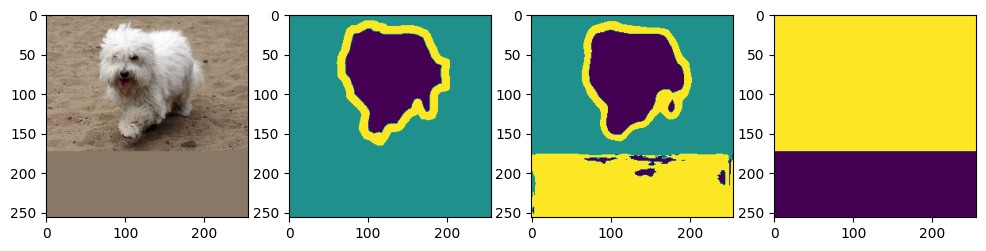

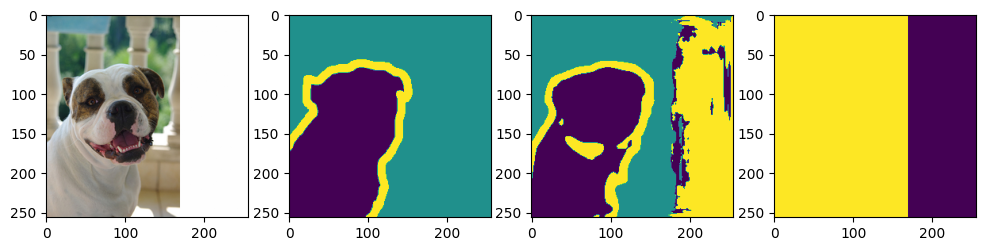

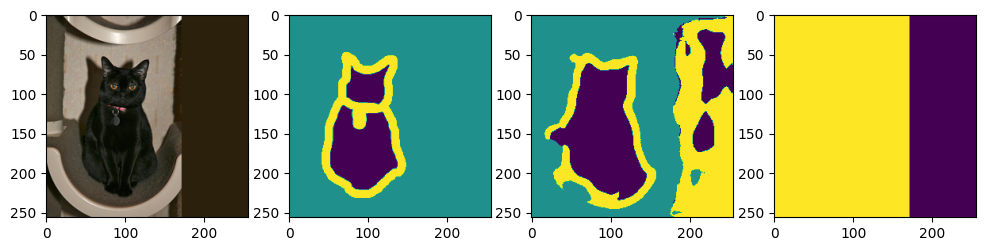

In [ ]:
img, label, mask, clf_label = next(iter(test_loader))

for i in range(5):
    inference(img[i], label[i], mask[i], finetune_model, device)